In [54]:
import numpy as np
import pandas as pd
import itertools as it
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score,confusion_matrix,recall_score,accuracy_score
from sklearn.metrics import roc_curve, auc,precision_recall_curve, roc_curve
import tsne
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pa

## Carga de Datos

In [26]:
DataIn = pd.read_excel('Data.xlsx')
DataIn = DataIn.set_index('Date')
Data = DataIn.dropna(axis=0,how='any')
Y = Data['Class']
X = Data.drop('Class', axis = 1)

# Definición de funciones para optimización de hyper parametros

###  Construcción de clases de hipótesis

Vamos utilizar en este caso el objeto llamado *Random Hyperparameter Grid* el cual permite generar un grid de hiperparámetros, de los cuales seleccionaremos un rango de hiperparametros y luego mediante la evaluación de estos modelos bajo un n optimo, escogeremos el mejor.

#### Descripción de parámetros

- Número de arboles.
- Número máximo de niveles por árbol.
- Mínimo número de muestras requeridas para cada nodo hoja.

In [27]:
n_arboles = [i for i in range(50,500,50)]
max_profundidad_arbol =  [i for i in range(1,4)]
max_profundidad_arbol.append(None)
min_muestras_hojas = [i for i in range(1,10)]

In [28]:
random_grid = {'n_estimators': n_arboles,
               'max_depth': max_profundidad_arbol,
               'min_samples_leaf': min_muestras_hojas}

In [40]:
Hyper_Parameters = [n_arboles, # n_estimators -> nro de arboles en el bosque
                    max_profundidad_arbol,       # max_depth
                    min_muestras_hojas]      # min_samples_leaf
Epsilon = 0.2
delta = 0.1
set_parameters = [i for i in it.product(*Hyper_Parameters)]

In [30]:
sample_size = X.shape[0]
training_sample_size = int(sample_size * 0.6)
validation_sample_size = int(sample_size * 0.2)
test_sample_size = validation_sample_size

## División de datos en: Entrenamiento, Pruebas, Validación.

*Dividimos la muestra en 60 % de Entrenamiento, 20% de Pruebas y 20% de Validación.*


- n: Número mínimo optimo/estimado de elementos para que el modelo aprenda. Serán los datos que utilizaremos para entrenar el modelo. Se sacan del 60% total de la muestra.
- validation_data: 20 % del total de la muestra.

In [31]:
def split_data_for_model_training(X, Y, training_sample_size, validation_sample_size):
    X_tr, X_ts, Y_tr, Y_ts = train_test_split(X,
                                              Y, 
                                              train_size = training_sample_size, 
                                              test_size = validation_sample_size*2, 
                                              random_state=19)
    
    X2_va, X2_ts, Y2_va, Y2_ts = train_test_split(X_ts, 
                                                  Y_ts, 
                                                  train_size = 0.5, 
                                                  random_state=19)
    return X_tr, Y_tr, X2_va, Y2_va, X2_ts, Y2_ts

## Utilitario para construir un modelo con los parametros dados:

El random forest al no tener un VC finito, no podemos calcular el n optimo de aprendizaje. Utilizaremos el GridSearchCV para avergiguar cuales son los parámetros óptimos.

In [32]:
def best_parameters(training_data_x, training_data_y):
    randForestClassi = RandomForestClassifier()
    clf = GridSearchCV(RandomForestClassifier(), random_grid, cv = 5)
    clf.fit(training_data_x, training_data_y)
    return clf.best_params_

In [33]:
X_tr, Y_tr, X2_va, Y2_va, X2_ts, Y2_ts  = split_data_for_model_training(X, Y, training_sample_size, validation_sample_size)

bootstrap=True, 

class_weight=None, 

criterion='gini',

max_depth=1, 

max_features='auto', 

max_leaf_nodes=None, 

min_impurity_decrease=0.0,

min_impurity_split=None, 

min_samples_leaf=1, 

min_samples_split=2, 

min_weight_fraction_leaf=0.0,

n_estimators=400, 

n_jobs=None, 

oob_score=False, 

random_state=19, 

verbose=0, 

warm_start=False

In [34]:
a = best_parameters(X_tr, Y_tr)

In [44]:
def building_a_random_forest_model(validation_data_x, validation_data_y,
                                  training_data_x, training_data_y,
                                  n, 
                                  n_estimators, 
                                  max_depth,
                                  min_samples_leaf):
    
    randCla = RandomForestClassifier(n_estimators = n_estimators,
                                 max_depth = max_depth,
                                 min_samples_leaf = min_samples_leaf,
                                 random_state=19)
    
    X_tr, X_ts, Y_tr, Y_ts = train_test_split(training_data_x, 
                                              training_data_y, 
                                              train_size = n,
                                              random_state=19)
    
    ## Training the data
    randCla.fit(X_tr, Y_tr)
    y_pred = randCla.predict(validation_data_x)
    a_score = accuracy_score(validation_data_y, y_pred)
    return randCla, y_pred, a_score

## Accuracy de random forest con  scoring alto, según grid search: 

Jugando con varios N y validando con la muestra de validación.


In [36]:
def show_me_the_money(validation_data_x, validation_data_y,
                      training_data_x, training_data_y,
                      n_estimators, 
                      max_depth,
                      min_samples_leaf):
    N = []
    Score = []
    for i in range(20, len(training_data_x), 5):
        if i  > len(training_data_x):
            return N, Score
        else: 
            clf, y_pred, a_score = building_a_random_forest_model(validation_data_x, validation_data_y,
                                   training_data_x, training_data_y,
                                   i, 
                                   n_estimators, 
                                   max_depth,
                                   min_samples_leaf)
            N.append(i)
            Score.append(a_score)
    return N, Score

In [ ]:
N, Score = show_me_the_money(X2_va, Y2_va, X_tr, Y_tr, n_estimators=400, max_depth = 1, min_samples_leaf=1)

In [ ]:
plt.plot(N,Score)

## Cálculo de n min estimado; aplica para todas las clases de hipotesis:

- error de experto "delta"
- error de entrenamiento "epsilon"
- conjunto de hiperparametros "h_aprox"

In [37]:
def estim_n_for_tree(epsilon, h_aprox, delta):
    return int(np.ceil((1/epsilon)*(np.log(h_aprox) + np.log(1/delta))))

# Modelos - N mínimo estimado

Aquí encontramos el árbol con el *score* mas alto y mas bajo, utilizando el n mínimo estimado
, para todas las clases de hipotesis.

In [38]:
def main_fun_min_estimado(epsilon, delta, validation_data_x, validation_data_y,
                          training_data_x, training_data_y, n, _set_parameters):
    results = []
    # TODO - Add Try/Catch
    for p in _set_parameters:        
        # Validamos si n esta dentro del sample
        if n > len(training_data_x):
            return results
        else: 
             clf, y_pred, a_score = building_a_random_forest_model(validation_data_x, 
                                                                   validation_data_y,
                                                                   training_data_x, training_data_y,
                                                                   n,
                                                                   p[0],
                                                                   p[1],
                                                                   p[2])
        results.append((clf, a_score))
    return results

In [45]:
n_min_estimado = estim_n_for_tree(Epsilon, len(set_parameters),delta)
print("n min estimado:")
print(n_min_estimado)      

w_s = main_fun_min_estimado(Epsilon, delta, X2_ts, Y2_ts, X_tr, Y_tr, n_min_estimado, set_parameters)


n min estimado:
41


D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

## Arbol con scoring mas alto

In [46]:
max(w_s, key = lambda t: t[1])

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=1, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
             oob_score=False, random_state=19, verbose=0, warm_start=False),
 0.48466257668711654)

## Arbol con scoring mas bajo

In [47]:
min(w_s, key = lambda t: t[1])

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
             oob_score=False, random_state=19, verbose=0, warm_start=False),
 0.4269938650306748)

## Bajaremos de dimensión

In [50]:
T = tsne.tsne(X = X, perplexity=60)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 4075...
Computing P-values for point 500 of 4075...
Computing P-values for point 1000 of 4075...
Computing P-values for point 1500 of 4075...
Computing P-values for point 2000 of 4075...
Computing P-values for point 2500 of 4075...
Computing P-values for point 3000 of 4075...
Computing P-values for point 3500 of 4075...
Computing P-values for point 4000 of 4075...
Mean value of sigma: 0.727629
Iteration 10: error is 21.836991
Iteration 20: error is 20.406703
Iteration 30: error is 17.509641
Iteration 40: error is 16.536907
Iteration 50: error is 16.308329
Iteration 60: error is 16.174306
Iteration 70: error is 16.096223
Iteration 80: error is 15.939433
Iteration 90: error is 15.887774
Iteration 100: error is 15.903212
Iteration 110: error is 2.355026
Iteration 120: error is 2.043995
Iteration 130: error is 1.827900
Iteration 140: error is 1.682277
Iteration 150: error is 1.577083
Itera

In [55]:
def plot(x, colors):
    palette = np.array(sns.color_palette("hls", 10))  #Choosing color palette 

    # Create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    # Add the labels for each digit.
    txts = []
    for i in range(-1,2,1):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([pa.Stroke(linewidth=5, foreground="w"), pa.Normal()])
        txts.append(txt)
    return f, ax, txts

In [52]:
T.shape[0]

4075

(<Figure size 576x576 with 1 Axes>,
 [Text(-3.1535241665262332, 3.303788994591223, '-1'),
  Text(3.853282382958846, -3.2488911336304898, '0'),
  Text(-2.8860881101878495, 3.68035729163021, '1')])

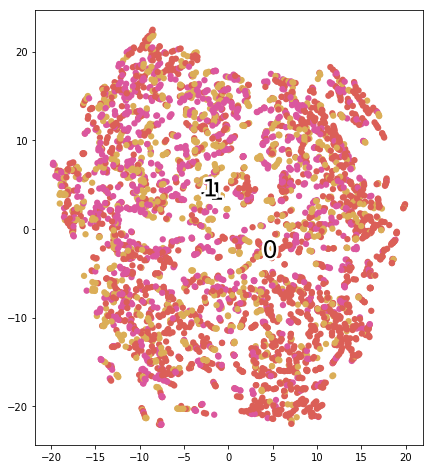

In [56]:
plot(T, Y.values)

## Seleccionaremos el mejor modelo con ésta dimensión

In [57]:
embbebed_X_tr, embbebed_Y_tr, embbebed_X2_va, embbebed_Y2_va, embbebed_X2_ts, embbebed_Y2_ts  = split_data_for_model_training(T,Y, training_sample_size, validation_sample_size)

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [58]:
w_embbebed = main_fun_min_estimado(Epsilon, delta, embbebed_X2_ts, embbebed_Y2_ts, embbebed_X_tr, embbebed_Y_tr, n_min_estimado, set_parameters)


D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

In [59]:
max(w_embbebed, key = lambda t: t[1])

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=9, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
             oob_score=False, random_state=19, verbose=0, warm_start=False),
 0.4368098159509202)

In [60]:
min(w_embbebed, key = lambda t: t[1])

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=1, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=3, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
             oob_score=False, random_state=19, verbose=0, warm_start=False),
 0.36073619631901843)

In [62]:
N_embbebed, Score_embbebed = show_me_the_money(embbebed_X2_va, embbebed_Y2_va, embbebed_X_tr, embbebed_Y_tr, n_estimators=400, max_depth = 1, min_samples_leaf=1)

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
D:\Usuarios\juanespe\AppData\Local\Continuum\anaconda3\lib\s

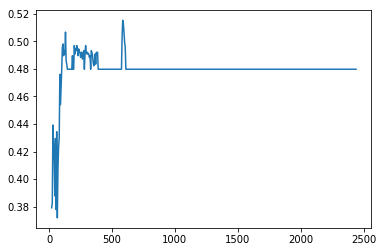

In [63]:
plt.plot(N_embbebed,Score_embbebed)